In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
#import regionmask
import pandas as pd
import xesmf as xe

## Import our data

#### Import GC output

In [3]:
GC_new = xr.open_mfdataset('../../GCrundirs/test_hemco_level/geosfp_4x5_standard/output_6hr/GEOSChem.SpeciesConc.201601*_0000z.nc4', combine = 'by_coords') #dataset with the kgC/m2/s and kgNO2/m2/s
GC_orig = xr.open_mfdataset('../../GCrundirs/test_NEI_jan_orig2011NEI/geosfp_4x5_standard/output_2013/GEOSChem.SpeciesConc.201601*_0000z.nc4', combine = 'by_coords') #2013 scaled NEI

GC_new.attrs['name'] = 'EPA2016'
GC_orig.attrs['name'] = 'NEI2011'

datasets = [GC_new,
            GC_orig]

for ds in datasets:
    ds*=1e9 #convert to ppb
    #sum our NO and NO2
    ds['NOx'] = ds['SpeciesConc_NO'] + ds['SpeciesConc_NO2']

#### Import HEMCO diagnostics

In [6]:
HEMCO_new = xr.open_mfdataset('../../GCrundirs/standalone_monthly/hemco_4x5_geosfp/OutputDir/HEMCO_diagnostics.201601*.nc', combine = 'by_coords')
HEMCO_orig = xr.open_dataset('../../GCrundirs/benchmark_jan_NEI/geosfp_4x5_benchmark/OutputDir/')

HEMCO_new.attrs['name'] = 'EPA2016'
HEMCO_orig.attrs['name'] = 'NEI2011'

datasets = [HEMCO_new,
           HEMCO_orig]

OSError: no files to open

## Plot Diurnal Cycle

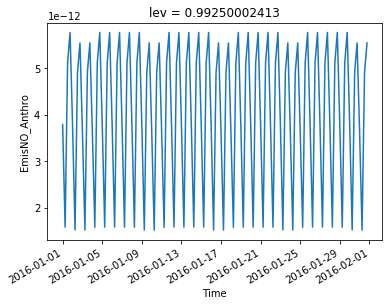

In [54]:
HEMCO_new['EmisNO_Anthro'].sel(lon = slice(-140,-50), lat = slice(0,70)).mean(dim = ['lat','lon']).isel(lev = 0).plot()


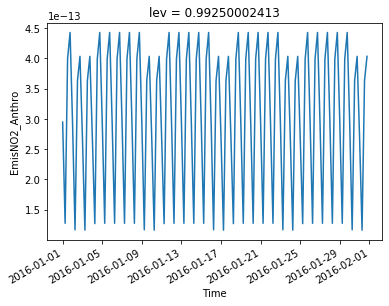

In [55]:
HEMCO_new['EmisNO2_Anthro'].sel(lon = slice(-140,-50), lat = slice(0,70)).mean(dim = ['lat','lon']).isel(lev = 0).plot()


## Plot the NOx for each GC run

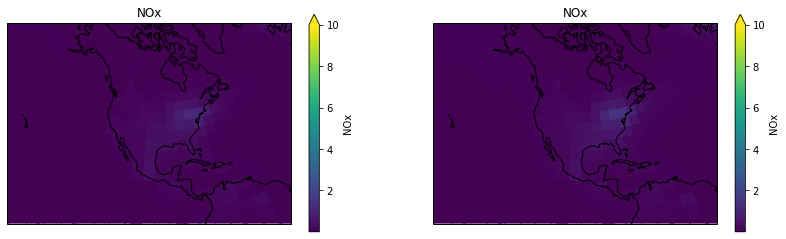

In [10]:
#### plot our NO2 for each dataset ####
datasets = [GC_new,
            GC_orig]

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ds['NOx'].isel(lev = 6).mean(dim = 'time').plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis',
                                        vmax = 10)
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'NOx')


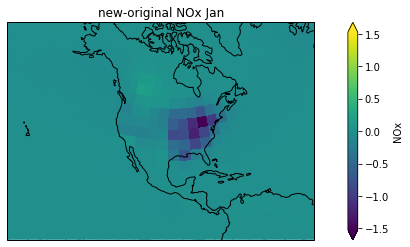

In [11]:
#### plot the difference in NO2 for our original and new files ####

fig, ax = plt.subplots(figsize = [12,4], subplot_kw={'projection':ccrs.LambertConformal()})
(GC_new['NOx'].isel(lev = 2).mean(dim = 'time') - 
 GC_orig['NOx'].isel(lev = 2).mean(dim = 'time')).plot(ax=ax, #set the axis
                                   extend='both',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis'
                                   )
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])
ax.set_title(f'NOx');
plt.title('new-original NOx Jan');


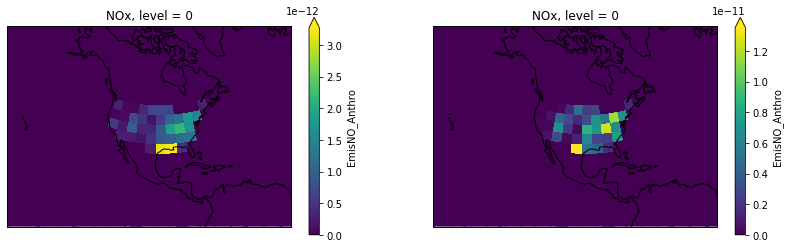

In [13]:
#### plot our NOx of HEMCO Emissions ####
datasets = [HEMCO_new,
            HEMCO_orig]

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ds['EmisNO_Anthro'].isel(lev = 1).mean(dim = 'time').plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis')
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'NOx, level = 0')


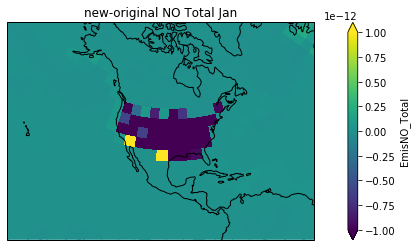

In [18]:
#### plot the difference in NO2 for our original and new files HEMCO ####
lev = 0
fig, ax = plt.subplots(figsize = [12,4], subplot_kw={'projection':ccrs.LambertConformal()})
(HEMCO_new['EmisNO_Total'].isel(lev = lev).mean(dim = 'time') - 
 HEMCO_orig['EmisNO_Total'].isel(lev = lev).mean(dim = 'time')).plot(ax=ax, #set the axis
                                   extend='both',#extend the colorbar in both directions
                                   transform=ccrs.PlateCarree(), #fit data into map
                                    cmap='viridis',
                                   vmax = 1e-12)
ax.coastlines()
ax.set_extent([-150, -50, 0, 70])
ax.set_title(f'NOx');
plt.title('new-original NO Total Jan');


## Mask our datasets to just the contiguous US

In [15]:
#### import our mask ####
mask = xr.open_dataset('../../masks/USA_mask.geos.1x1.nc')

In [20]:
#### create regridder (reusing weights) to regrid our mask to 4x5 resolution ####
regridder = xe.Regridder(mask.drop_dims('time'), HEMCO_new.drop_dims('time'), 'bilinear', reuse_weights = True)
regridder  # print basic regridder information.

#### regrid ####
regrid_mask = regridder(mask)

#### get rid of time dimension ####
regrid_mask = regrid_mask.squeeze('time')

Reuse existing file: bilinear_181x360_46x72.nc
using dimensions ('lat', 'lon') from data variable MASK as the horizontal dimensions for this dataset.


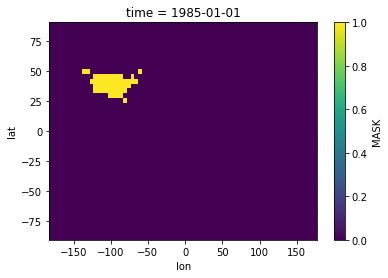

In [21]:
### plot our mask ####
regrid_mask['MASK'].plot()

In [22]:
HEMCO_new_US = HEMCO_new.where(regrid_mask['MASK'] ==1)
HEMCO_orig_US = HEMCO_orig.where(regrid_mask['MASK'] ==1)

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


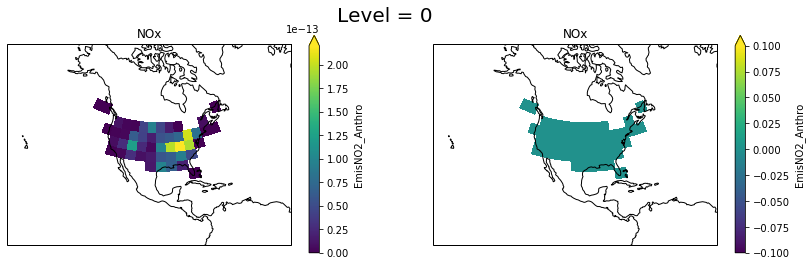

In [28]:
#### plot our NOx of HEMCO Emissions ####
datasets = [HEMCO_new_US,
            HEMCO_orig_US]

fig, axes = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.LambertConformal()})

for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ds['EmisNO2_Anthro'].isel(lev = 5).mean(dim = 'time').plot(ax=ax, #set the axis
                                       extend='max',#extend the colorbar in both directions
                                       transform=ccrs.PlateCarree(), #fit data into map
                                        cmap='viridis')
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'NOx')
plt.suptitle('Level = 0', fontsize = 20);


#### NO2 concentrations in our HEMCO diagnostics output

In [29]:

NOx_avgrate_orig = (HEMCO_orig_US['EmisNO_Anthro'].sum(dim = 'lev') +
                HEMCO_orig_US['EmisNO_BioBurn'] +
                HEMCO_orig_US['EmisNO2_Anthro'].sum(dim = 'lev')
                ).mean().values.item()

NOx_avgrate_new = (HEMCO_new_US['EmisNO_Anthro'].sum(dim = 'lev') +
                HEMCO_new_US['EmisNO_BioBurn'] +
                HEMCO_new_US['EmisNO2_Anthro'].sum(dim = 'lev')
               ).mean().values.item()

print(NOx_avgrate_new, 'average kg NOx/m2/s from new NEI')
print(NOx_avgrate_orig, 'average kg NOx/m2/s from old NEI')


2.0823355192933768e-11 average kg NOx/m2/s from new NEI
2.5476940002100434e-11 average kg NOx/m2/s from old NEI


In [230]:
lev = 0

NOx_avgrate_orig = (HEMCO_orig_US['EmisNO_Anthro'].isel(lev = lev) +
                HEMCO_orig_US['EmisNO_BioBurn'] +
                HEMCO_orig_US['EmisNO2_Anthro'].isel(lev = lev) #+
                ).mean().values.item()

NOx_avgrate_new = (HEMCO_new_US['EmisNO_Anthro'].isel(lev = lev) +
                HEMCO_new_US['EmisNO_BioBurn'] +
                HEMCO_new_US['EmisNO2_Anthro'].isel(lev = lev) #+
               ).mean().values.item()

print(NOx_avgrate_new, f'average kg NOx/m2/s from new NEI at lev = {lev}')
print(NOx_avgrate_orig, f'average kg NOx/m2/s from old NEI at lev = {lev}')



1.7525992809797053e-11 average kg NOx/m2/s from new NEI at lev = 0
2.0764672967188424e-11 average kg NOx/m2/s from old NEI at lev = 0


In [37]:
lev = 0
#first mutliply by area and seconds/month, then sum across levels, convert from kg NO or kg NO2 to kg N, finally sum all and convert to short tons
NOx_conc_orig = ((HEMCO_orig_US['EmisNO_Anthro'].isel(lev = lev)*m2_s_in_month) * no2_no * n_no2 +
                #(HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'orig')*m2_s_in_month) * no2_no * n_no2 +
                (HEMCO_orig_US['EmisNO2_Anthro'].isel(lev = lev)*m2_s_in_month) * n_no2
                ).sum().values.item() * 0.00110231

NOx_conc_new = ((HEMCO_new_US['EmisNO_Anthro'].isel(lev = lev)*m2_s_in_6hours) * no2_no * n_no2 +
                #(HEMCO_US_ds['EmisNO_BioBurn'].sel(name = 'new')*m2_s_in_6hours) * no2_no * n_no2 +
                (HEMCO_new_US['EmisNO2_Anthro'].isel(lev = lev)*m2_s_in_6hours) * n_no2
               ).sum().values.item() * 0.00110231

print(NOx_conc_new, 'short tons N from new NEI')
print(NOx_conc_orig, 'short tons N from old NEI')

220429.87914222505 short tons N from new NEI
261217.1555532344 short tons N from old NEI


In [38]:
m2_s_in_6hours =HEMCO_new_US['AREA'].isel(time = 0)* 60 * 60 * 6
m2_s_in_month = HEMCO_orig_US['AREA'] * 60 * 60 * 24 * 31
no2_no = 46.0055/30.01
n_no2 = 14.0067 / 46.0055 

#first mutliply by area and seconds/6 hours, then sum across levels, convert from kg NO or kg NO2 to kg N, finally sum all and convert to short tons
NOx_conc_orig = ((HEMCO_orig_US['EmisNO_Anthro']*m2_s_in_month).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_orig_US['EmisNO_BioBurn']*m2_s_in_month) * no2_no * n_no2 +
                (HEMCO_orig_US['EmisNO2_Anthro']*m2_s_in_month).sum(dim = 'lev') * n_no2
                ).sum().values.item() * 0.00110231

NOx_conc_new = ((HEMCO_new_US['EmisNO_Anthro']*m2_s_in_6hours).sum(dim = 'lev') * no2_no * n_no2 +
                (HEMCO_new_US['EmisNO_BioBurn']*m2_s_in_6hours) * no2_no * n_no2 +
                (HEMCO_new_US['EmisNO2_Anthro']*m2_s_in_6hours).sum(dim = 'lev') * n_no2
               ).sum().values.item() * 0.00110231


print(NOx_conc_new, 'short tons N from new NEI')
print(NOx_conc_orig, 'short tons N from old NEI')

261884.08233649557 short tons N from new NEI
320301.0639987929 short tons N from old NEI


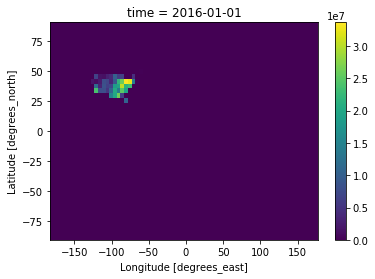

In [42]:
(HEMCO_orig_US['EmisNO_Anthro']*m2_s_in_month).sum(dim = 'lev').plot()

### Import reference data

In [195]:
monthlycounty = pd.read_excel('2011ek_county_monthly_report.xlsx', sheet_name = 'data')

In [196]:
monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'sector').sum()['jan_value'].drop(
    ['beis','ptfire','agfire','cmv'])

sector
nonpt              100011.717201
nonroad             80702.298394
np_oilgas           55805.711117
onroad             380361.625219
onroad_catx_adj     62300.771291
pt_oilgas           43292.677495
ptegu              206625.771302
ptnonipm           102524.124688
rail                67213.131517
rwc                  7599.175075
Name: jan_value, dtype: float64

In [189]:
monthlycounty2016 = pd.read_csv('2016fh_county_monthly_report_22jan2020_v0.csv', comment='#')

In [190]:
np.unique(monthlycounty2016['census_tract_cd'])

array(['afdust_adj', 'ag', 'airports', 'beis', 'cmv_c1c2_12', 'cmv_c3_12',
       'nonpt', 'nonroad', 'np_oilgas', 'onroad', 'onroad_ca_adj',
       'pt_oilgas', 'ptagfire', 'ptegu', 'ptfire', 'ptnonipm', 'rail',
       'rwc'], dtype=object)

In [191]:
month_abbrev = ['jan','feb','mar','apr','may','jun','jul','aug','sep','nov','dec']
month_value = [f'{month}_value' for month in month_abbrev]
month_value.append('ann_value')

In [197]:
NOx_ref2011 =  monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'sector').sum()['jan_value'].drop(
    ['beis','ptfire','agfire','cmv']).sum() #is this in tons N already? otherwise converting it gets unreasonable values

In [193]:
NOx_ref = monthlycounty.loc[
    monthlycounty['poll'] == 'NOX'].groupby(
    'census_tract_cd').sum()['jan_value'].drop(
    ['beis','ptfire','ptagfire', 'cmv_c1c2_12','cmv_c3_12']).sum() #is this in tons N already? otherwise converting it gets unreasonable values

In [201]:
print(NOx_ref, 'short tons N (no fire, beis, cmv)') 

786548.2492405875 short tons N (no fire, beis, cmv)


In [202]:
print('new NEI to reference', NOx_conc_new/NOx_ref)

new NEI to reference 0.33295361421164527
